In [1]:
%pylab inline
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
import cartopy
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import math as math
import matplotlib.animation as animation
from collections import Counter 
sys.path.insert(1, '../../functions/')
from ParticlePlotFunctions import *
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [42]:
# Load particle data
namefile = '../../input/particles/Beaching_200826.nc'
Traj = ReadTrajectories(namefile)
total_particles = Traj['lon'].shape[0]
release_loc = 675   #number of release locations
release_time = int(floor(total_particles/release_loc)) #number of releases at specific location 
total_particles = int(release_loc * release_time)

#thresholds:
distance_from_coast = 4 #in km
deploy_threshold = 0.8 # for permit deploy drifters where >80% chance of beaching

In [43]:
# Produce probability if no Stokes and no wind 
startlon = Traj['lon'][0:release_loc,0]
startlat = Traj['lat'][0:release_loc,0]
distance = Traj['distance'][:]
beaching_probability = np.zeros((release_loc))

for p in range(total_particles):
    index_loc = p%release_loc
    beached = np.where((distance[p,:] < distance_from_coast) & (distance[p,:] != 0))[0]
    if beached.any():
        beaching_probability[index_loc] += 1
print(sum(beaching_probability)/total_particles*100)

23.311338642396663


In [39]:
# Produce probability if Stokes or Wind
startlon = Traj['lon'][0:release_loc,0]
startlat = Traj['lat'][0:release_loc,0]
beached = Traj['beached'][:]
beaching_probability = np.zeros((release_loc))

for p in range(total_particles):
    index_loc = p%release_loc
    if beached[p,-1]==1:
        beaching_probability[index_loc] += 1
print(sum(beaching_probability)/total_particles*100)

12.292834890965732


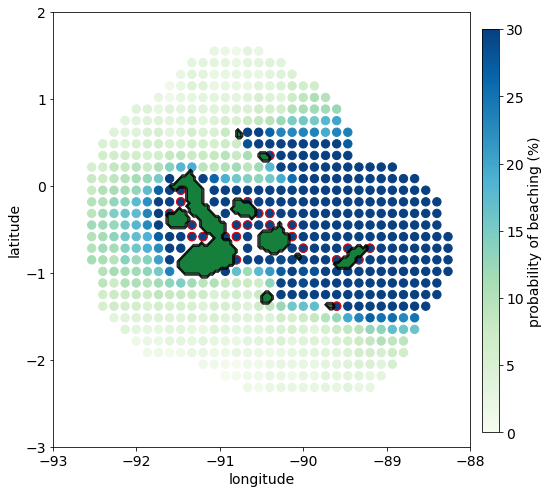

In [19]:
# Make figure if we have beaching probability for any island

galapagos_domain = [-93, -88, -3, 2]

Xfiles = '../../input/modelfields/MITgcm4km/RGEMS3_Surf_grid.nc'
dfile = Dataset(Xfiles)
mask0 = dfile.variables['maskC'][0,:,:]
mask1 = np.where(mask0==1, nan, 0)
lon = dfile.variables['XC'][:]
lat = dfile.variables['YC'][:]

deploy = np.zeros((release_loc))*nan        
deploy[np.where(beaching_probability/release_time>deploy_threshold)]=1

figsize=(8,8)
fig, axs = plt.subplots(1, 1, figsize=figsize)

im = axs.scatter(startlon,startlat,s=70,
                 c=beaching_probability/release_time*100,
                 cmap='GnBu',
                 vmin=0,vmax=30) 
axs.scatter(startlon*deploy,startlat*deploy,s=70,
            facecolors='none',
            edgecolors='r') 
axs.contourf(lon,lat,mask1,cmap='Greens',vmin=-4,vmax=1)
axs.contour(lon, lat, mask0, colors='k', linestyles='-', linewidths = 0.5)
axs.set_xlabel('longitude')                 
axs.set_ylabel('latitude') 

axs.set_xlim(galapagos_domain[0:2])
axs.set_ylim(galapagos_domain[2:4])

cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('probability of beaching (%)')
plt.rcParams.update({'font.size': 14})

fig.subplots_adjust(wspace=0.0, hspace=0.0, right=0.85)

plt.savefig('probability_of_beaching.png', dpi=300)

In [44]:
# Specify at which island drifter is likely to beach -> only advection

island = Traj['island'][:]
beaching_island = np.zeros((release_loc,release_time))
island_most = np.zeros((release_loc))

for p in range(total_particles):
    index_loc = p%release_loc
    index_release = math.floor(p/release_loc)
    beached = np.where((distance[p,:] < distance_from_coast) & (distance[p,:] != 0))[0]
    if beached.any():
        beaching_island[index_loc,index_release] = island[p,beached[0]]

for i in range(release_loc):
    if beaching_probability[i] > 0:
        occurence_count = Counter(beaching_island[i,:]) 
        most_frequent = occurence_count.most_common(2)
        if most_frequent[0][0]==0:
            island_most[i] = most_frequent[1][0]
        else:
            island_most[i] = most_frequent[0][0]
    

In [40]:
# Specify at which island drifter is likely to beach -> advection + wind/stokes

island = Traj['island'][:]
beached = Traj['beached'][:]
beaching_island = np.zeros((release_loc,release_time))
island_most = np.zeros((release_loc))

for p in range(total_particles):
    index_loc = p%release_loc
    index_release = math.floor(p/release_loc)
    if beached[p,-1]==1:
        beaching_island[index_loc,index_release] = island[p,-1]

for i in range(release_loc):
    if beaching_probability[i] > 0:
        occurence_count = Counter(beaching_island[i,:]) 
        most_frequent = occurence_count.most_common(2)
        if most_frequent[0][0]==0:
            island_most[i] = most_frequent[1][0]
        else:
            island_most[i] = most_frequent[0][0]

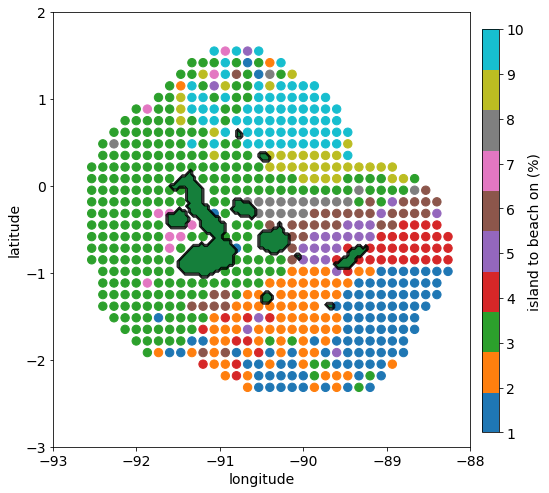

In [45]:
# Make figure to specify at which island drifter is likely to beach

galapagos_domain = [-93, -88, -3, 2]

Xfiles = '../../input/modelfields/MITgcm4km/RGEMS3_Surf_grid.nc'
dfile = Dataset(Xfiles)
mask0 = dfile.variables['maskC'][0,:,:]
mask1 = np.where(mask0==1, nan, 0)
lon = dfile.variables['XC'][:]
lat = dfile.variables['YC'][:]

figsize=(8,8)
fig, axs = plt.subplots(1, 1, figsize=figsize)

im = axs.scatter(startlon,startlat,s=70,
                 c=island_most,
                 cmap='tab10',
                 vmin=1,vmax=10) 
axs.contourf(lon,lat,mask1,cmap='Greens',vmin=-4,vmax=1)
axs.contour(lon, lat, mask0, colors='k', linestyles='-', linewidths = 0.5)
axs.set_xlabel('longitude')                 
axs.set_ylabel('latitude') 

axs.set_xlim(galapagos_domain[0:2])
axs.set_ylim(galapagos_domain[2:4])

cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('island to beach on (%)')
plt.rcParams.update({'font.size': 14})

fig.subplots_adjust(wspace=0.0, hspace=0.0, right=0.85)

plt.savefig('beaching_island.png', dpi=300)

In [46]:
# Individual pathways
namefile = '../../input/particles/Beaching_200826.nc'
TrajAdv = ReadTrajectories(namefile)
namefile = '../../input/particles/Beaching_200826_wstokes.nc'
TrajStokes = ReadTrajectories(namefile)
namefile = '../../input/particles/Beaching_200826_wind0010.nc'
TrajWind = ReadTrajectories(namefile)
namefile = '../../input/particles/Beaching_200826_wstokes_wind0010.nc'
TrajStokesWind = ReadTrajectories(namefile)

total_particles = TrajStokesWind['lon'].shape[0]
release_loc = 675   #number of release locations
release_time = int(floor(total_particles/release_loc)) #number of releases at specific location 
total_particles = int(release_loc * release_time)

In [63]:
# find which particles beach

startlon = TrajStokes['lon'][0:release_loc,0]
startlat = TrajStokes['lat'][0:release_loc,0]
beached = TrajStokes['beached'][:]
beaching = np.where(beached[:,-1]==1)

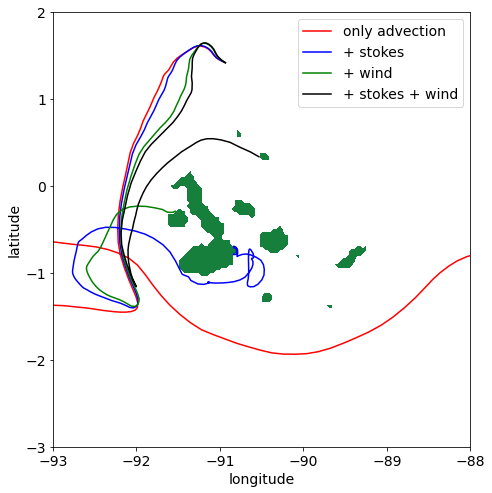

In [69]:
# plot individual pathways based on particles that beach in the wind+stokes scenario

i = 350

galapagos_domain = [-93, -88, -3, 2]
#galapagos_domain = [-90.6, -89.8, -1.6, 0]

Xfiles = '../../input/modelfields/MITgcm4km/RGEMS3_Surf_grid.nc'
dfile = Dataset(Xfiles)
mask0 = dfile.variables['maskC'][0,:,:]
mask1 = np.where(mask0==1, nan, 0)
lon = dfile.variables['XC'][:]
lat = dfile.variables['YC'][:]

figsize=(8,8)
fig, axs = plt.subplots(1, 1, figsize=figsize)

axs.contourf(lon,lat,mask1,cmap='Greens',vmin=-4,vmax=1)

axs.plot(TrajAdv['lon'][beaching[0][i],:],TrajAdv['lat'][beaching[0][i],:],'r',label = 'only advection')
axs.plot(TrajStokes['lon'][beaching[0][i],:],TrajStokes['lat'][beaching[0][i],:],'b',label = '+ stokes')
axs.plot(TrajWind['lon'][beaching[0][i],:],TrajWind['lat'][beaching[0][i],:],'g',label = '+ wind')
axs.plot(TrajStokesWind['lon'][beaching[0][i],:],TrajStokesWind['lat'][beaching[0][i],:],'k',label = '+ stokes + wind')

axs.set_xlabel('longitude')                 
axs.set_ylabel('latitude') 
axs.set_xlim(galapagos_domain[0:2])
axs.set_ylim(galapagos_domain[2:4])
axs.legend()

plt.rcParams.update({'font.size': 14})

fig.subplots_adjust(wspace=0.0, hspace=0.0, right=0.85)

plt.savefig('individual_pathways3.png', dpi=300)

In [89]:
# check land masks of advection field, wave field and wind field

Xfiles = '../../input/modelfields/MITgcm4km/RGEMS3_Surf_grid.nc'
dfile = Dataset(Xfiles)
mask0 = dfile.variables['maskC'][0,:,:]
mask1 = np.where(mask0==1, nan, 0)
lon = dfile.variables['XC'][:]
lat = dfile.variables['YC'][:]

Xfiles = '../../input/modelfields/WaveWatch/WW3-GLOB-30M_200801_uss.nc'
dfile = Dataset(Xfiles)
mask_stokes = dfile.variables['uuss'][0,:,:]
lon_stokes = dfile.variables['longitude'][:]
lat_stokes = dfile.variables['latitude'][:]

Xfiles = '../../input/modelfields/CMEMSwind/2008010100-IFR-L4-EWSB-BlendedWind-GLO-025-6H-REPv6-20190114T114032-fv1.0.nc'
dfile = Dataset(Xfiles)
mask_wind = dfile.variables['eastward_wind'][0,:,:]
lon_wind = dfile.variables['lon'][:]
lat_wind = dfile.variables['lat'][:]

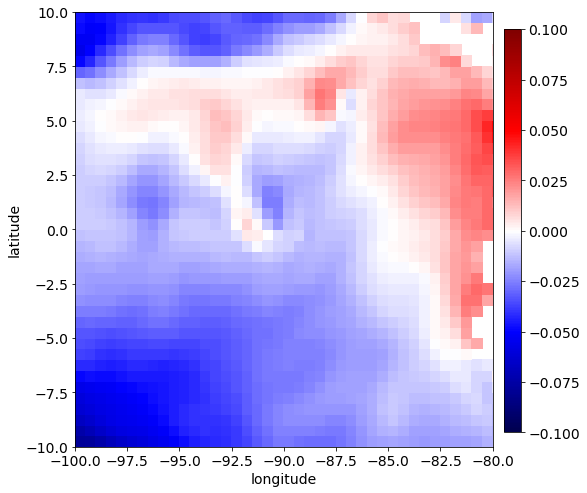

In [91]:
galapagos_domain = [-100, -80, -10, 10]

figsize=(8,8)
fig, axs = plt.subplots(1, 1, figsize=figsize)

im=axs.pcolor(lon_stokes,lat_stokes,mask_stokes,cmap='seismic',vmin=-0.1, vmax = 0.1)
axs.set_xlabel('longitude')                 
axs.set_ylabel('latitude') 
axs.set_xlim(galapagos_domain[0:2])
axs.set_ylim(galapagos_domain[2:4])

cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
fig.subplots_adjust(wspace=0.0, hspace=0.0, right=0.85)
plt.savefig('Uwaves_20080101.png', dpi=300)

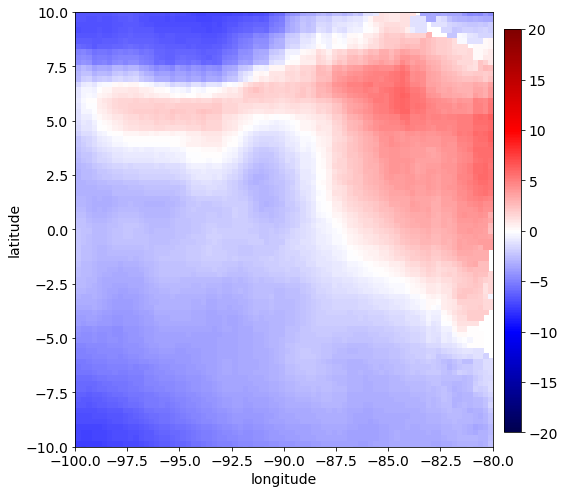

In [92]:
galapagos_domain = [-100, -80, -10, 10]

figsize=(8,8)
fig, axs = plt.subplots(1, 1, figsize=figsize)

im=axs.pcolor(lon_wind,lat_wind,mask_wind,cmap='seismic',vmin=-20, vmax = 20)
axs.set_xlabel('longitude')                 
axs.set_ylabel('latitude') 
axs.set_xlim(galapagos_domain[0:2])
axs.set_ylim(galapagos_domain[2:4])

cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
fig.subplots_adjust(wspace=0.0, hspace=0.0, right=0.85)
plt.savefig('Uwind_20080101.png', dpi=300)